In [367]:
from scipy import integrate as inte
import numpy as np
import matplotlib.pyplot as plt
from numpy import log as ln
G = 6.67E-11 # m^3 kg^-1 s^-2

from astropy.table import QTable
from scipy.optimize import curve_fit
import astropy.units as u
from scipy.special import kn
from scipy.special import iv
from scipy.optimize import minimize
import dynesty
from dynesty import plotting as dyplot

DTable1 = QTable.read('7443-12701_rot_curve_data.txt', format='ascii.ecsv')
DTable2 = QTable.read('7443-12702_rot_curve_data.txt', format='ascii.ecsv')
DTable3 = QTable.read('7443-12703_rot_curve_data.txt', format='ascii.ecsv')
DTable4 = QTable.read('7443-12704_rot_curve_data.txt', format='ascii.ecsv')
DTable5 = QTable.read('7443-12705_rot_curve_data.txt', format='ascii.ecsv')
DTable1

deprojected_distance,max_velocity,max_velocity_error,min_velocity,min_velocity_error,rot_vel_avg,rot_vel_avg_error,sMass_interior,sVel_rot,sVel_rot_error,dmMass_interior,dmMass_interior_error,dmVel_rot,dmVel_rot_error,mass_interior,mass_interior_error,rot_curve_diff,rot_curve_diff_error
kpc,km / s,km / s,km / s,km / s,km / s,km / s,solMass,km / s,km / s,solMass,solMass,km / s,km / s,solMass,solMass,km / s,km / s
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.2976342931275581,28.710186074985074,3.4793001923216,-41.525063243948594,3.08635311942519,35.117624659466834,4.65092522043461,444431537.5282246,80.13855269734559,0.00090052761372742,-359087704.2861601,22605617.077569474,nan,nan,85343833.24206445,22605617.077569474,12.81487716896352,4.65092522043461
0.5952685862551162,30.94383630202276,3.34570262697779,-726.5322134962166,10.889223747336601,378.7380248991197,11.391616210517515,1430299850.274661,101.65707483312708,0.0011423341193060742,18422862571.842278,1194279991.9367032,364.84014395466164,11.825559374015812,19853162422.11694,1194279991.9367032,695.5883771941939,11.391616210517515
0.8929028793826743,533.2374106827352,14.9770573601962,-871.5507006539951,17.535057721438,702.3940556683651,23.060583177031095,2542025959.0459123,110.65433264314325,0.0012434375062906587,99882695045.88216,6725495232.786925,693.6231167612242,23.35218939994765,102424721004.92807,6725495232.786925,338.3132899712599,23.060583177031095
1.1905371725102325,525.4588921457537,12.7337153578087,-828.5756035203203,21.2380202116844,677.017247833037,24.76289581865595,3371004571.159104,110.35416654606941,0.0012400644997910201,123505538528.00336,9281390620.17823,667.9628071901476,25.098566770408947,126876543099.16246,9281390620.17823,303.11671137456665,24.76289581865595
1.4881714656377907,516.8829207462054,11.5072831534216,-831.9469039794527,42.5476916934467,674.414912362829,44.076338709262295,4019838082.219327,107.78500295394626,0.0012111944655688192,153358956135.19757,20570960146.225906,665.7460981151748,44.65026689405092,157378794217.4169,20570960146.225906,315.0639832332473,44.076338709262295
1.7858057587653486,497.70194024923194,37.5704598829431,-833.6765709918113,33.3811898888884,665.6892556205216,50.25776849616248,4664326822.732419,105.98829880543379,0.0011910046612240287,179334996186.5152,27782919443.582733,657.1975848745445,50.907151809410514,183999323009.24762,27782919443.582733,335.9746307425794,50.25776849616248
2.083440051892907,604.8307041703143,59.1020643567762,-799.1092253523257,50.0754661395059,701.9699647613199,77.46358060612302,5271489420.4243145,104.31738930023188,0.00117222842807746,233431017782.74893,52682456320.68505,694.1755640445668,78.33336452104966,238702507203.17325,52682456320.68505,194.27852118201133,77.46358060612302
2.381074345020465,555.5781008592216,27.6788836092953,-803.8708034098258,46.3787070745961,679.7244521345237,54.01023113973969,5744583066.423838,101.86460920367757,0.0011446662107300867,250041937089.07858,40649087055.18651,672.0483109281361,54.627137501982915,255786520155.5024,40649087055.18651,248.2927025506042,54.01023113973969


In [368]:
# bulge 
gamma = 3.3308 # unitless
kappa = gamma*ln(10) # unitless

def sigma_b(x,a,b):
    '''
    parameters:
    x (projected radius): The projected rdius  (pc)
    a (central density): The central density of the bulge (M_sol/pc^2)
    b (central radius): The central radius of the bulge (kpc)
    
    return: surface density of the bulge (g/pc^2)
    '''
    return a*np.exp(-1*kappa*((x/b)**0.25-1)) #M_sol/pc^2
                           
# derivative of sigma with respect to r
def dsdx(x,a,b):
    '''
    parameters:
    x (projected radius): The projected rdius  (pc)
    a (central density): The central density of the bulge (M/pc^2)
    b (central radius): The central radius of the bulge (kpc)
    
    return: derivative of sigma (g/pc^3)
    '''
    return sigma_b(x,a,b)*(-0.25*kappa)*(b**-0.25)*(x**-0.75) # M_sol/pc^2 \\

# integrand for getting denisty
def density_integrand(x,r,a,b):
    '''
    parameters:
    x (projected radius): The projected rdius  (pc)   
    r (radius): The a distance from the centre (pc)
    a (central density): The central density of the bulge (M/pc^2)
    b (central radius): The central radius of the bulge (kpc)
    
    return: integrand for volume density of the bulge (g/pc^3)
    '''
    return -(1/np.pi)*dsdx(x,a,b)/np.sqrt(x**2-r**2)

def mass_integrand(r,a,b):
    '''
    parameters:
    x (projected radius): The projected rdius  (pc)   
    r (radius): The a distance from the centre (pc)
    a (central density): The central density of the bulge (M/pc^2)
    b (central radius): The central radius of the bulge (kpc)
    
    return: volume density of the bulge
    '''
    vol_den, vol_den_err = inte.quad(density_integrand, r, np.inf, args=(r,a,b))
    return 4*np.pi*vol_den*r**2
    
# getting a velocity
def vel_b(r,a,b):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    a (central density): The central density of the bulge (M/pc^2)
    b (central radius): The central radius of the bulge (kpc)
    
    return: rotational velocity of the bulge (pc/s)
    '''
    if isinstance(r, float):
        bulge_mass, m_err = inte.quad(mass_integrand, 0, r, args=(Sigma_be, Rb))
    else:
        bulge_mass = np.zeros(len(r))
        err = np.zeros(len(r))
        
        for i in range(len(r)):
            bulge_mass[i],err[i] = inte.quad(mass_integrand, 0, r[i], args=(a,b))
    vel = np.sqrt(G*(bulge_mass*1.988E30)/(r*3.08E16))
    vel /= 1000
    return vel


# Disk velocity from Paolo 2018

def v_d(r,c,d):
    '''
    parameters:  
    r (radius): The a distance from the centre (pc)
    c (mass of disk): The total mass Xof the disk (M)
    d (disk radius): The central radius of the disk (pc)
    
    return: integrand for volume density of the disk
    '''
    bessel_component = (iv(0,r/(2*d))*kn(0,r/(2*d))-iv(1,r/(2*d))*kn(1,r/(2*d)))
    vel = ((0.5)*G*(1.988E30*c)*(r/d)**2/(d*3.08E16))*bessel_component
    return np.sqrt(vel)/1000


# halo (isothermal)
# e = rho_0_iso
# f = h

def rho0_iso(e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (rotational velocity): The rotational velocity when r approaches infinity (km/s)
    f (scale radius): The scale radius of the dark matter halo (pc)
    
    return: volume density of the isothermal halo (g/pc^3)
    '''
    return 0.740*(e/200)*(f)**(-2)

def rho_iso(r,e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (rotational velocity): The rotational velocity when r approaches infinity (km/s)
    f (scale radius): The scale radius of the dark matter halo (pc)
    
    return: volume density of the isothermal halo (g/pc^3)
    '''
    rho_0 = rho0_iso(e, f/1000)
    return rho_0/(1 + (r/f)**2)

def integrand_h_iso(r,e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (rotational velocity): The rotational velocity when r approaches infinity (km/s)
    f (scale radius): The scale radius of the dark matter halo (pc)

    return: integrand for getting the mass of the isothermal halo 
    '''
    
    return 4*np.pi*(rho_iso(r,e,f))*r**2

def mass_h_iso(r,e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (rotational velocity): The rotational velocity when r approaches infinity (km/s)
    f (scale radius): The scale radius of the dark matter halo (pc)
    
    return: mass of the isothermal halo (g)
    '''
    halo_mass, m_err = inte.quad(integrand_h_iso, 0, r, args=(e, f))
    return halo_mass

def vel_h_iso(r,e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (rotational velocity): The rotational velocity when r approaches infinity (km/s)
    f (scale radius): The scale radius of the dark matter halo (pc)
    
    return: rotational velocity of the isothermal halo (pc/s)
    '''
    if isinstance(r, float):
        halo_mass = mass_h_iso(r,e,f)
    else:
        halo_mass = np.zeros(len(r))
        for i in range(len(r)):
            halo_mass[i] = mass_h_iso(r[i],e,f)
    vel = np.sqrt(G*(halo_mass*1.988E30)/(r*3.08E16))
    vel /= 1000
    return vel


# halo (NFW)
# e = rho_0_NFW
# f = h

def rho_NFW(r,e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (central density): The central density of the halo (M_sol/pc^3)
    f (scale radius): The scale radius of the dark matter halo (pc)
    
    return: volume density of the isothermal halo (M/pc^3)
    '''
    return  (e)/((r/f)*((1+(r/f))**2))

def integrand_h_NFW(r,e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (central density): The central density of the halo (M_sol/pc^3)
    f (scale radius): The scale radius of the dark matter halo (pc)
    
    return: integrand for getting the mass of the isothermal halo 
    '''
    
    return 4*np.pi*(rho_NFW(r,e,f))*r**2

def mass_h_NFW(r,e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (central density): The central density of the halo (M_sol/pc^3)
    f (scale radius): The scale radius of the dark matter halo (pc)
    
    return: mass of the isothermal halo (g)
    '''
    halo_mass, m_err = inte.quad(integrand_h_NFW, 0, r, args=(e, f))
    return halo_mass

def vel_h_NFW(r,e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (central density): The central density of the halo (M_sol/pc^3)
    f (scale radius): The scale radius of the dark matter halo (pc)
    
    return: rotational velocity of the NFW halo (pc/s)
    '''
    if isinstance(r, float):
        halo_mass = mass_h_NFW(r,e,f)
    else:
        halo_mass = np.zeros(len(r))
        for i in range(len(r)):
            halo_mass[i] = mass_h_NFW(r[i],e,f)
    vel = np.sqrt(G*(halo_mass*1.98843E30)/(r*3.0857E16))
    vel /= 1000
    return vel


# halo (Burket)
# e = rho_0_Bur
# f = h

def rho_Burket(r,e,f):
    '''
    parameters:
    r (radius): The distance from the centre (pc)
    e (central density): The central density of the halo (M_sol/pc^3)
    f (scale radius): The scale radius of the dark matter halo (pc)
    
    return: volume density of the isothermal halo (M/pc^3)
    '''
    return  (e*f**3)/((r + f)*(r**2+f**2))

def integrand_h_Burket(r,e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (central density): The central density of the halo (M_sol/pc^3)
    f (scale radius): The scale radius of the dark matter halo (pc)
    
    return: integrand for getting the mass of the isothermal halo 
    '''
    
    return 4*np.pi*(rho_Burket(r,e,f))*r**2

def mass_h_Burket(r,e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (central density): The central density of the halo (M_sol/pc^3)
    f (scale radius): The scale radius of the dark matter halo (pc)
    
    return: mass of the isothermal halo (g)
    '''
    halo_mass, m_err = inte.quad(integrand_h_Burket, 0, r, args=(e, f))
    return halo_mass

def vel_h_Burket(r,e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (central density): The central density of the halo (M_sol/pc^3)
    f (scale radius): The scale radius of the dark matter halo (pc)
    
    return: rotational velocity of the Burket halo (pc/s)
    '''
    if isinstance(r, float):
        halo_mass = mass_h_Burket(r,e,f)
    else:
        halo_mass = np.zeros(len(r))
        for i in range(len(r)):
            halo_mass[i] = mass_h_Burket(r[i],e,f)
    vel = np.sqrt(G*(halo_mass*1.98843E30)/(r*3.0857E16))
    vel /= 1000
    return vel

In [369]:
# Combined Velocity of Isothermal Model
def v_co_iso(r,a,b,c,d,e,f):
    '''
    r (radius): The a distance from the centre (kpc)
    c (central surface density): The central surface density of the disk (M/pc^2)
    d (radius radius): The central radius of the disk (kpc)
    e (rotational velocity): The rotational velocity when r approaches infinity (km/s)
    f (scale radius): The scale radius of the dark matter halo (kpc)
    '''
    
    return np.sqrt(vel_b(r,a,b)**2+v_d(r,c,d)**2 + vel_h_iso(r,e,f)**2) #km/s


# Combined Velocity of Isothermal Model (No Bulge)
def v_co_iso_nb(r,c,d,e,f):
    '''
    r (radius): The a distance from the centre (pc)
    c (central surface density): The central surface density of the disk (M/pc^2)
    d (radius radius): The central radius of the disk (pc)
    e (rotational velocity): The rotational velocity when r approaches infinity (km/s)
    f (scale radius): The scale radius of the dark matter halo (pc)
    '''
    return np.sqrt(v_d(r,c,d)**2 + vel_h_iso(r,e,f)**2) #km/s


# Combined Velocity of NFW Model
def v_co_NFW(r,a,b,c,d,e,f):
    '''
    r (radius): The a distance from the centre (pc)
    c (central surface density): The central surface density of the disk (M/pc^2)
    d (radius radius): The central radius of the disk (pc)
    e (central density): The central density of the halo (M_sol/pc^3)
    f (scale radius): The scale radius of the dark matter halo (pc)
    '''
    return np.sqrt(vel_b(r,a,b)**2+v_d(r,c,d)**2 + vel_h_NFW(r,e,f)**2) #km/s


# Combined Velocity of NFW Model (No Bulge)
def v_co_NFW_nb(r,c,d,e,f):
    '''
    r (radius): The a distance from the centre (pc)
    c (central surface density): The central surface density of the disk (M/pc^2)
    d (radius radius): The central radius of the disk (pc)
    e (central density): The central density of the halo (M_sol/pc^3)
    f (scale radius): The scale radius of the dark matter halo (pc)
    '''
    return np.sqrt(v_d(r,c,d)**2 + vel_h_NFW(r,e,f)**2) #km/s


# Combined Velocity of Burket Model
def v_co_Burket(r,a,b,c,d,e,f):
    '''
    r (radius): The a distance from the centre (pc)
    c (central surface density): The central surface density of the disk (M/pc^2)
    d (radius radius): The central radius of the disk (pc)
    e (central density): The central density of the halo (M_sol/pc^3)
    f (scale radius): The scale radius of the dark matter halo (pc)
    '''
    return np.sqrt(vel_b(r,a,b)**2+v_d(r,c,d)**2 + vel_h_Burket(r,e,f)**2) #km/s


# Combined Velocity of Burket Model (No Bulge)
def v_co_Burket_nb(r,c,d,e,f):
    '''
    r (radius): The a distance from the centre (kpc)
    c (central surface density): The central surface density of the disk (M/pc^2)
    d (radius radius): The central radius of the disk (kpc)
    e (central density): The central density of (M/pc^3)
    f (scale radius): The scale radius of the dark matter halo (kpc)
    '''
    r *= 1000
    d *= 1000
    f *= 1000
    return np.sqrt(v_d(r,c,d)**2 + vel_h_Burket(r,e,f)**2) #km/s

In [370]:
r_1=DTable1['deprojected_distance'].data
r_2=DTable2['deprojected_distance'].data
r_3=DTable3['deprojected_distance'].data
r_4=DTable4['deprojected_distance'].data
r_5=DTable5['deprojected_distance'].data
av_1=DTable1['rot_vel_avg'].data
av_2=DTable2['rot_vel_avg'].data
av_3=DTable3['rot_vel_avg'].data
av_4=DTable4['rot_vel_avg'].data
av_5=DTable5['rot_vel_avg'].data
mav_1=DTable1['max_velocity'].data
mav_2=DTable2['max_velocity'].data
mav_3=DTable3['max_velocity'].data
mav_4=DTable4['max_velocity'].data
mav_5=DTable5['max_velocity'].data
miv_1=DTable1['min_velocity'].data
miv_2=DTable2['min_velocity'].data
miv_3=DTable3['min_velocity'].data
miv_4=DTable4['min_velocity'].data
miv_5=DTable5['min_velocity'].data
av_1_err=DTable1['rot_vel_avg_error'].data
av_2_err=DTable2['rot_vel_avg_error'].data
av_3_err=DTable3['rot_vel_avg_error'].data
av_4_err=DTable4['rot_vel_avg_error'].data
av_5_err=DTable5['rot_vel_avg_error'].data
mav_1_err=DTable1['max_velocity_error'].data
mav_2_err=DTable2['max_velocity_error'].data
mav_3_err=DTable3['max_velocity_error'].data
mav_4_err=DTable4['max_velocity_error'].data
mav_5_err=DTable5['max_velocity_error'].data
miv_1_err=DTable1['min_velocity_error'].data
miv_2_err=DTable2['min_velocity_error'].data
miv_3_err=DTable3['min_velocity_error'].data
miv_4_err=DTable4['min_velocity_error'].data
miv_5_err=DTable5['min_velocity_error'].data

# No good velocity Curve

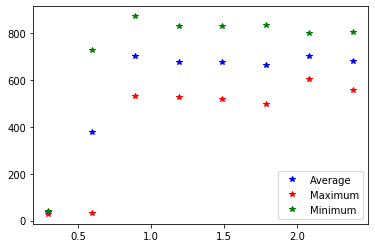

In [371]:
plt.plot(r_1,av_1,'b*',label='Average')
plt.plot(r_1,mav_1,'r*',label='Maximum')
plt.plot(r_1,np.abs(miv_1),'g*',label='Minimum')
plt.legend()

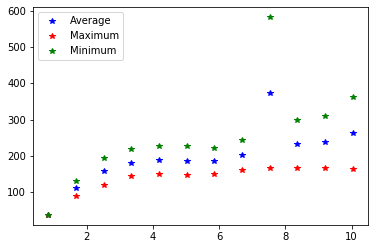

In [372]:
plt.plot(r_2,av_2,'b*',label='Average')
plt.plot(r_2,mav_2,'r*',label='Maximum')
plt.plot(r_2,np.abs(miv_2),'g*',label='Minimum')
plt.legend()

# Merger

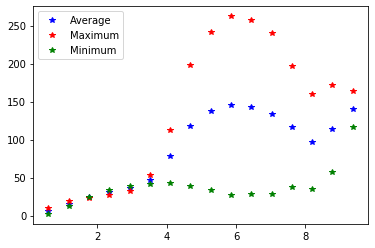

In [373]:
plt.plot(r_3,av_3,'b*',label='Average')
plt.plot(r_3,mav_3,'r*',label='Maximum')
plt.plot(r_3,np.abs(miv_3),'g*',label='Minimum')
plt.legend()

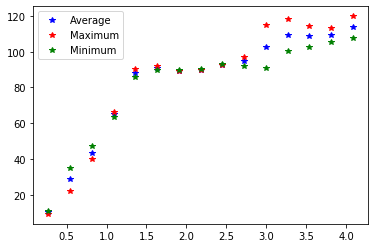

In [374]:
plt.plot(r_4,av_4,'b*',label='Average')
plt.plot(r_4,mav_4,'r*',label='Maximum')
plt.plot(r_4,np.abs(miv_4),'g*',label='Minimum')
plt.legend()

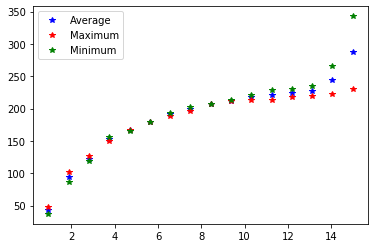

In [375]:
plt.plot(r_5,av_5,'b*',label='Average')
plt.plot(r_5,mav_5,'r*',label='Maximum')
plt.plot(r_5,np.abs(miv_5),'g*',label='Minimum')
plt.legend()

# 7443-12702 

In [376]:
# Bounds 
p0= [5E10,3,2E-2,2E2]

# Average Velocity

In [377]:
# Loglike function
def loglike_Bur_ave_2(theta):
    a,b,c,d = theta
    model = v_co_Burket_nb(np.array(r_2),a,b,c,d)
    inv_sigma2 = 1.0 / (np.array(av_2_err)**2)
    
    return -0.5 * (np.sum((np.array(av_2)-model)**2 * inv_sigma2 - np.log(inv_sigma2)))

In [378]:
# Negative likelihood

nloglike_Bur_ave_2 = lambda theta: -loglike_Bur_ave_2(theta)

In [379]:
bestfit_av_2 = minimize(nloglike_Bur_ave_2,p0,bounds=((0,1E11),(0,10),(0,1E-1),(0,1E2)))
bestfit_av_2

/Users/richardzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in true_divide
/Users/richardzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
/Users/richardzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in multiply


      fun: nan
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  6.23822004e+01, -2.83548064e+03, -3.38019390e-02])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 105
      nit: 0
   status: 2
  success: False
        x: array([5.e+10, 3.e+00, 2.e-02, 1.e+02])

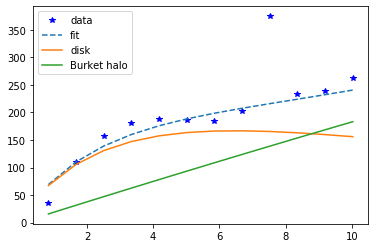

In [380]:
plt.plot(r_2,av_2,'b*',label='data')
plt.plot(r_2,v_co_Burket_nb(np.array(r_2),*bestfit_av_2.x),'--',label='fit')
plt.plot(r_2,v_d(np.array(r_2)*1000,bestfit_av_2.x[0],bestfit_av_2.x[1]*1000),label='disk')
plt.plot(r_2,vel_h_Burket(np.array(r_2)*1000,bestfit_av_2.x[2],bestfit_av_2.x[3]*1000),label='Burket halo')
plt.legend()

# Maximum Velocity

In [381]:
# Bounds
p1= [6E10,4.5,1E-2,1E2]

In [382]:
# Loglike function
def loglike_Bur_mav_2(theta):
    a,b,c,d = theta
    model = v_co_Burket_nb(np.array(r_2)*1000,a,b,c,d)
    inv_sigma2 = 1.0 / (np.array(mav_2_err)**2)
    
    return -0.5 * (np.sum((np.array(mav_2)-model)**2 * inv_sigma2 - np.log(inv_sigma2)))

In [383]:
# Negative likelihood

nloglike_Bur_mav_2 = lambda theta: -loglike_Bur_mav_2(theta)

In [384]:
bestfit_mav_2 = minimize(nloglike_Bur_mav_2,p1,bounds=((0,1E11),(0,10),(0,1E-1),(0,1E2)))
bestfit_mav_2

/Users/richardzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in multiply
/Users/richardzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:259: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


      fun: nan
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([nan, nan, nan, nan])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 105
      nit: 0
   status: 2
  success: False
        x: array([6.0e+10, 4.5e+00, 1.0e-02, 1.0e+02])

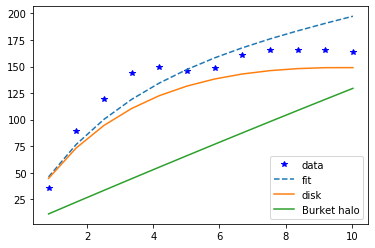

In [385]:
plt.plot(r_2,mav_2,'b*',label='data')
plt.plot(r_2,v_co_Burket_nb(np.array(r_2),*bestfit_mav_2.x),'--',label='fit')
plt.plot(r_2,v_d(np.array(r_2)*1000,bestfit_mav_2.x[0],bestfit_mav_2.x[1]*1000),label='disk')
plt.plot(r_2,vel_h_Burket(np.array(r_2)*1000,bestfit_mav_2.x[2],bestfit_mav_2.x[3]*1000),label='Burket halo')
plt.legend()

# Minimum Velocity

In [386]:
# Bounds 
p2= [7E10,5,1E-1,2E2]

In [354]:
# Loglike function
def loglike_Bur_miv_2(theta):
    a,b,c,d = theta
    model = v_co_Burket_nb(np.array(r_2)*1000,a,b,c,d)
    inv_sigma2 = 1.0 / (np.array(miv_2_err)**2)
    
    return -0.5 * (np.sum((np.array(np.abs(miv_2))-model)**2 * inv_sigma2 - np.log(inv_sigma2)))

In [355]:
# Negative likelihood

nloglike_Bur_miv_2 = lambda theta: -loglike_Bur_miv_2(theta)

In [356]:
bestfit_miv_2 = minimize(nloglike_Bur_miv_2,p1,bounds=((0,1E11),(0,10),(0,1E-1),(0,1E2)))
bestfit_miv_2

/Users/richardzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in multiply
/Users/richardzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:259: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


      fun: nan
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([nan, nan, nan, nan])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 105
      nit: 0
   status: 2
  success: False
        x: array([6.0e+10, 4.5e+00, 1.0e-02, 1.0e+02])

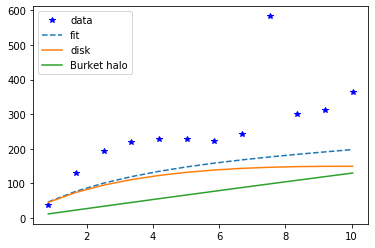

In [357]:
plt.plot(r_2,np.abs(miv_2),'b*',label='data')
plt.plot(r_2,v_co_Burket_nb(np.array(r_2),*bestfit_miv_2.x),'--',label='fit')
plt.plot(r_2,v_d(np.array(r_2)*1000,bestfit_miv_2.x[0],bestfit_miv_2.x[1]*1000),label='disk')
plt.plot(r_2,vel_h_Burket(np.array(r_2)*1000,bestfit_miv_2.x[2],bestfit_miv_2.x[3]*1000),label='Burket halo')
plt.legend()

# Dynamic Nested Sampler (Average Velocity)

In [359]:
# Burket 
# disk mass --> log(M_sol)
# halo radius --> kpc
def loglike_Bur(theta,r,vel,vel_err):
    a,b,c,d = theta
    model = v_co_Burket_nb(r*1000,a,b,c,d)
    model[model<=0] = np.finfo(dtype=np.float64).tiny
    inv_sigma2 = 1.0 / (vel_err**2)
    '''
    loss = -0.5 * (np.sum((vel-model)**2 * inv_sigma2 - np.log(inv_sigma2)))
    if b >= d:
        loss += l000
    '''
    return -0.5 * (np.sum((vel-model)**2 * inv_sigma2 - np.log(inv_sigma2)))

In [360]:
# Random Distribution Functions

def uniform(a, b, u):
    """Given u in [0,1], return a uniform number in [a,b]."""
    return a + (b-a)*u
def jeffreys(a, b, u):
    #"""Given u in [0,1], return a Jeffreys random number in [a,b]."""
    return a**(1-u) * b**u

In [365]:
def ptform_Bur(u):
    """
    Priors for the 4 parameters of Burket rotation curve model. 
    Required by the dynesty sampler.
    Parameters
    ----------
    u : ndarray
        Array of uniform random numbers between 0 and 1.
    Returns
    -------
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    """
    M_disk = uniform(1E8,1E11,u[0])
    R_disk = uniform(2, 10,u[1])
    Rho_halo = uniform(5E-4,5E-2,u[2])
    #R_halo = jeffreys(9E2,1E7,u[3])
    R_halo = jeffreys(10,500,u[3])
    return M_disk, R_disk, Rho_halo, R_halo

In [366]:
dsampler = dynesty.DynamicNestedSampler(loglike_Bur, ptform_Bur, ndim=4,
                                        logl_args=(np.array(r_2), 
                                                   np.array(av_2), 
                                                   np.array(av_2_err)),
                                        nlive=2000,
                                        bound='multi',
                                        sample='auto')
dsampler.run_nested()
dres1 = dsampler.results

0it [00:00, ?it/s]/Users/richardzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in multiply
/Users/richardzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys
0it [00:02, ?it/s]


ValueError: The log-likelihood (nan) of live point 0 located at u=[0.24723556 0.42499132 0.71456777 0.32354091] v=[2.47988327e+10 5.39993055e+00 3.58711044e-02 3.54557194e+01]  is invalid.

In [ ]:
labels = ['$M_{disk}$', '$R_{disk}$', '$rho_{hc}$','$R_{halo}$']
nParams = len(labels)
fig, axes = dyplot.cornerplot(dres1, smooth=0.03,
                              labels=labels,
                              show_titles=True,
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1.,2.,3]],
                              quantiles=[0.16, 0.5, 0.84],
                              fig=plt.subplots(nParams, nParams, figsize=(2.5*nParams, 2.6*nParams)),
                              color='#1f77d4')

# Dynamic Nested Sampler (Maximum Velocity)

In [333]:
dsampler2 = dynesty.DynamicNestedSampler(loglike_Bur, ptform_Bur, ndim=4,
                                        logl_args=(np.array(r_2), 
                                                   np.array(mav_2), 
                                                   np.array(mav_2_err)),
                                        nlive=2000,
                                        bound='multi',
                                        sample='auto')
dsampler2.run_nested()
dres2 = dsampler.results

24577it [03:56, 103.91it/s, batch: 9 | bound: 106 | nc: 2 | ncall: 97133 | eff(%): 25.302 | loglstar: -63.738 < -55.080 < -56.135 | logz: -65.749 +/-  0.177 | stop:  0.939]         


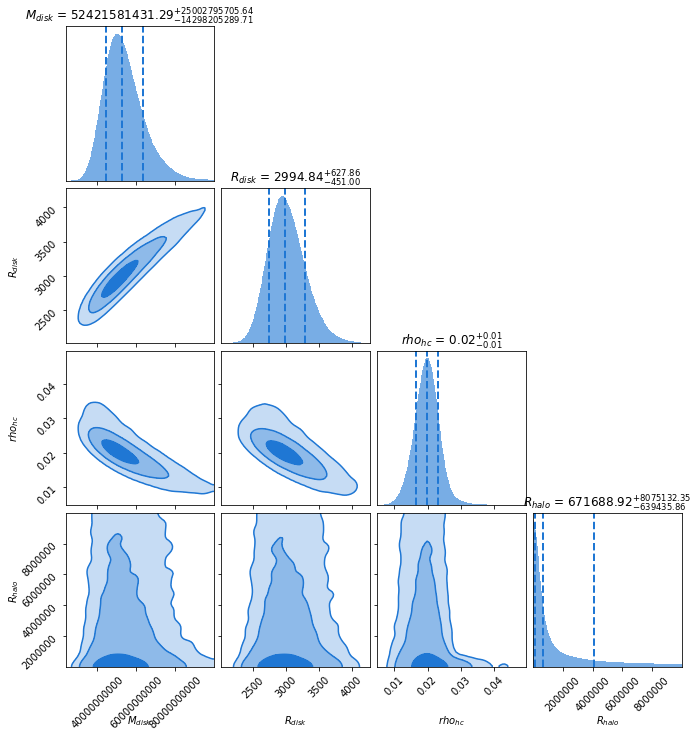

In [334]:
labels = ['$M_{disk}$', '$R_{disk}$', '$rho_{hc}$','$R_{halo}$']
nParams = len(labels)
fig, axes = dyplot.cornerplot(dres2, smooth=0.03,
                              labels=labels,
                              show_titles=True,
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1.,2.,3]],
                              quantiles=[0.16, 0.5, 0.84],
                              fig=plt.subplots(nParams, nParams, figsize=(2.5*nParams, 2.6*nParams)),
                              color='#1f77d4')

# Dynamic Nested Sampler (Minimum Velocity)

In [388]:
dsampler3 = dynesty.DynamicNestedSampler(loglike_Bur, ptform_Bur, ndim=4,
                                        logl_args=(np.array(r_2), 
                                                   np.array(miv_2), 
                                                   np.array(miv_2_err)),
                                        nlive=2000,
                                        bound='multi',
                                        sample='auto')
dsampler3.run_nested()
dres3 = dsampler.results

27303it [09:53, 45.98it/s, batch: 8 | bound: 89 | nc: 1 | ncall: 82126 | eff(%): 33.245 | loglstar: -27269.072 < -27262.062 < -27263.282 | logz: -27284.177 +/-  0.276 | stop:  0.958]     


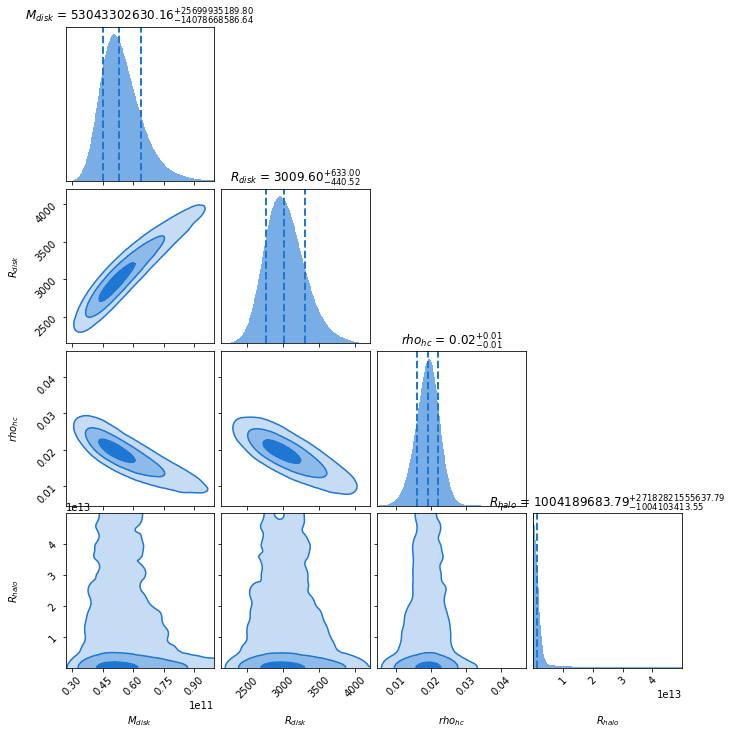

In [389]:
labels = ['$M_{disk}$', '$R_{disk}$', '$rho_{hc}$','$R_{halo}$']
nParams = len(labels)
fig, axes = dyplot.cornerplot(dres3, smooth=0.03,
                              labels=labels,
                              show_titles=True,
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1.,2.,3]],
                              quantiles=[0.16, 0.5, 0.84],
                              fig=plt.subplots(nParams, nParams, figsize=(2.5*nParams, 2.6*nParams)),
                              color='#1f77d4')

# 12704

In [393]:
# Bounds 
p4 = [5.24E10,2.99E3,2E-2,5E8]

In [398]:
# Loglike function
def loglike_Bur_ave_4(theta):
    a,b,c,d,e,f = theta
    model = v_co_Burket(np.array(r_4)*1000,a,b,c,d,e,f)
    inv_sigma2 = 1.0 / (np.array(av_4_err)**2)
    
    return -0.5 * (np.sum((np.array(av_4)-model)**2 * inv_sigma2 - np.log(inv_sigma2)))

In [403]:
# Negative likelihood

nloglike_Bur_ave_4 = lambda theta: -loglike_Bur_ave_4(theta)

In [404]:
bestfit_av_4 = minimize(nloglike_Bur_ave_4,p0,bounds=((),(),(1E8,1E11),(2E3,1E4),(5E-4,5E-2),(1E3,1E13)))
bestfit_av_4

      fun: 56.388205194592075
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00, -5.68434189e-06,  1.10305867e+03,  0.00000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 75
      nit: 8
   status: 0
  success: True
        x: array([5.2400000e+10, 4.1600002e+03, 5.0000000e-04, 5.0000000e+08])

In [ ]:
plt.plot(r_2,av_2,'b*',label='data')
plt.plot(r_2,v_co_Burket_nb(np.array(r_2)*1000,*bestfit_av_2.x),'--',label='fit')
plt.plot(r_2,v_d(np.array(r_2)*1000,bestfit_av_2.x[0],bestfit_av_2.x[1]),label='disk')
plt.plot(r_2,vel_h_Burket(np.array(r_2)*1000,bestfit_av_2.x[2],bestfit_av_2.x[3]),label='Burket halo')
plt.legend()